# Back-and-Forth 1D Demo (smooth + nonsmooth mix)


In [1]:

# Environment + imports
import sys
from pathlib import Path
repo_root = str(Path.cwd().parents[1])
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from methods.back_and_forth.method import backnforth_sqeuclidean_nd
from methods.back_and_forth.pushforward import adaptive_pushforward_nd

sns.set_theme(style='whitegrid', context='talk')
jax.config.update('jax_enable_x64', True)
print('JAX ready:', jax.__version__)


JAX ready: 0.8.0


In [2]:

# Plotting helpers
sns.set_theme(style='whitegrid', context='paper')
palette = sns.color_palette('deep')
plt.rcParams.update({
    'figure.dpi': 120,
    'axes.titlesize': 11,
    'axes.labelsize': 10,
    'legend.fontsize': 12,
})


### Smooth + nonsmooth 1D example

We transport two probability measures supported on $[0,1]$ that mix smooth Gaussian bumps and flat indicator pieces. The source density is
$$
\mu(x) \propto 0.6 e^{-\frac{(x-0.3)^2}{0.01}} + 0.4 \cdot \mathbf{1}_{(0.55,0.75)}(x),\\
\nu(x) \propto 0.5 e^{-\frac{(x-0.7)^2}{0.008}} + 0.3 \cdot \mathbf{1}_{(0.15,0.25)}(x) + 0.2 \cdot \mathbf{1}_{|x-0.45|<0.05}(x).
$$
We discretize these functions on the uniform grid, clip negative values, and renormalize so that $\sum_i \mu_i = \sum_i \nu_i = 1$.


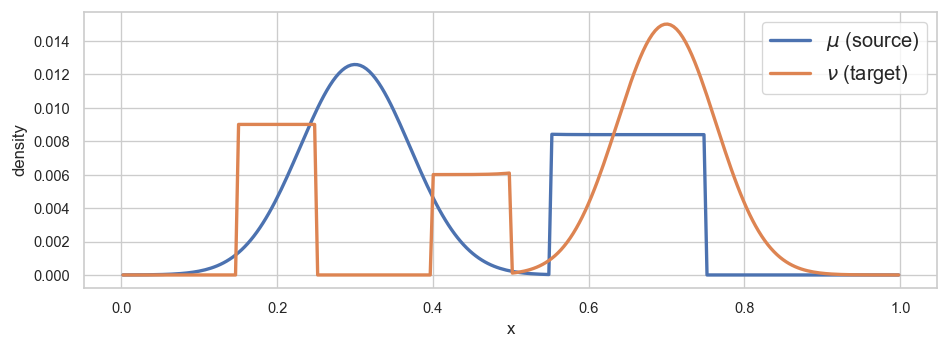

In [28]:

# 1D smooth + nonsmooth distributions on [0,1]
n = 256
x = np.linspace(0.5/n, 1 - 0.5/n, n)

mu_np = 0.6 * np.exp(-((x - 0.3)**2) / 0.01)
mu_np += 0.4 * ((x > 0.55) & (x < 0.75)).astype(float)

nu_np = 0.5 * np.exp(-((x - 0.7)**2) / 0.008)
nu_np += 0.3 * ((x > 0.15) & (x < 0.25)).astype(float)
nu_np += 0.2 * ((np.abs(x - 0.45) < 0.05)).astype(float)

mu_np = np.clip(mu_np, 0, None)
nu_np = np.clip(nu_np, 0, None)
mu_np /= mu_np.sum()
nu_np /= nu_np.sum()

mu = jax.device_put(mu_np)
nu = jax.device_put(nu_np)
coords = [jnp.asarray(x, dtype=jnp.float64)]

fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(x, mu_np, label=r'$\mu$ (source)', linewidth=2)
ax.plot(x, nu_np, label=r'$\nu$ (target)', linewidth=2)
ax.set_xlabel('x')
ax.set_ylabel('density')
ax.legend()
plt.tight_layout()
plt.show()


In [29]:
stepsize = 1 / max(mu_np.max(), nu_np.max())
max_iter = 80
result = backnforth_sqeuclidean_nd(
    mu, nu, coords,
    stepsize=stepsize,
    maxiterations=max_iter,
    tolerance=1e-12,
    progressbar=False,
    pushforward_fn=adaptive_pushforward_nd,
    error_metric='h1_psi',
    )
(iterations, phi, psi, rho_nu, rho_mu, errors, dual_values, sigma_hist) = result
iterations = int(iterations)

print(f"Finished in {iterations} outer iterations")

Finished in 80 outer iterations


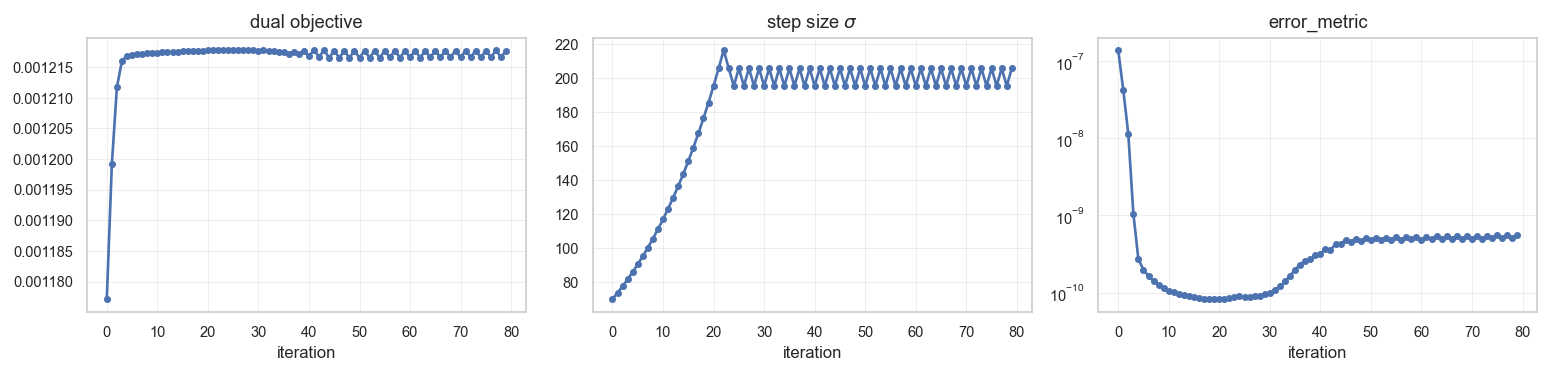

In [30]:

# Diagnostics: dual value, stepsize, and error evolution
metrics = {
    'dual objective': np.array(dual_values[:iterations]),
    r'step size $\sigma$': np.array(sigma_hist[:iterations]),
    'error_metric': np.clip(np.array(errors[:iterations]), 1e-12, None),
}

fig, axes = plt.subplots(1, 3, figsize=(13, 3.2))
for ax, (title, data) in zip(axes, metrics.items()):
    ax.plot(np.arange(iterations), data, marker='o', linewidth=1.6, markersize=3.2,
            color=palette[0])
    ax.set_title(title)
    ax.set_xlabel('iteration')
    if title == 'error_metric':
        ax.set_yscale('log')
    ax.grid(True, linewidth=0.4, alpha=0.5)
plt.tight_layout()
plt.show()


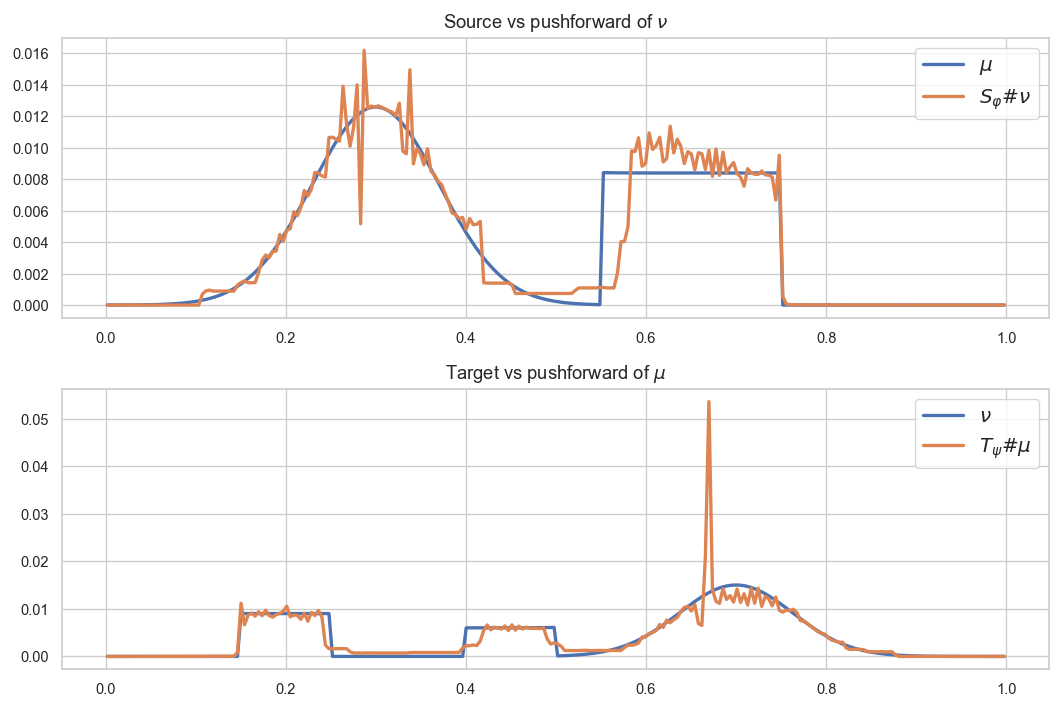

TV(T_psi#mu, nu) = 1.155e-01
TV(S_varphi#nu, mu) = 8.144e-02


In [31]:

# Compare pushforwards vs original measures (1D)
rho_mu_np = np.array(rho_mu)
rho_nu_np = np.array(rho_nu)
residual_mu = rho_mu_np - nu_np
residual_nu = rho_nu_np - mu_np

fig, axes = plt.subplots(2, 1, figsize=(9, 6))
axes[0].plot(x, mu_np, label=r'$\mu$', linewidth=2)
axes[0].plot(x, rho_nu_np, label=r'$S_{\varphi}\#\nu$', linewidth=2)
axes[0].set_title(r'Source vs pushforward of $\nu$')
axes[0].legend()

axes[1].plot(x, nu_np, label=r'$\nu$', linewidth=2)
axes[1].plot(x, rho_mu_np, label=r'$T_{\psi}\#\mu$', linewidth=2)
axes[1].set_title(r'Target vs pushforward of $\mu$')
axes[1].legend()
plt.tight_layout()
plt.show()

mu_tv = 0.5 * np.sum(np.abs(residual_nu))
nu_tv = 0.5 * np.sum(np.abs(residual_mu))
print(f"TV(T_psi#mu, nu) = {nu_tv:.3e}")
print(f"TV(S_varphi#nu, mu) = {mu_tv:.3e}")


### Mixture-of-Gaussians example

Here both measures are symmetric mixtures of two narrow Gaussian bumps centered at different locations:
$$
\mu(x) \propto \tfrac{1}{2} e^{-\frac{(x-0.25)^2}{0.01}} + \tfrac{1}{2} e^{-\frac{(x-0.65)^2}{0.01}},\\
\nu(x) \propto \tfrac{1}{2} e^{-\frac{(x-0.40)^2}{0.01}} + \tfrac{1}{2} e^{-\frac{(x-0.80)^2}{0.01}}.
$$
Evaluating these expressions on the grid, multiplying by the cell volume, and renormalizing approximates mixture-of-Gaussian probability densities restricted to $[0,1]$.


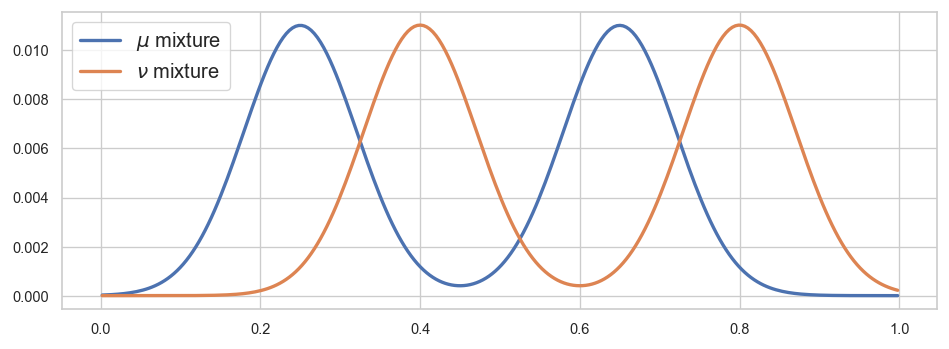

Mixture example converged in 9 iterations


In [7]:

# Additional example: mixture of Gaussians
x2 = np.linspace(0.5/n, 1 - 0.5/n, n)
cell_vol2 = x2[1] - x2[0]
mu_mean1, mu_mean2 = 0.25, 0.65
mu_sigma1, mu_sigma2 = 0.01, 0.01
nu_mean1, nu_mean2 = 0.4, 0.8
nu_sigma1, nu_sigma2 = 0.01, 0.01
mu_mix = 0.5 * np.exp(-((x2 - mu_mean1)**2)/mu_sigma1) + 0.5 * np.exp(-((x2 - mu_mean2)**2)/mu_sigma2)
nu_mix = 0.5 * np.exp(-((x2 - nu_mean1)**2)/nu_sigma1) + 0.5 * np.exp(-((x2 - nu_mean2)**2)/nu_sigma2)
mu_mix *= cell_vol2
nu_mix *= cell_vol2
mu_mix /= mu_mix.sum()
nu_mix /= nu_mix.sum()

mu_mix_j = jax.device_put(mu_mix)
nu_mix_j = jax.device_put(nu_mix)
coords_mix = [jnp.asarray(x2, dtype=jnp.float64)]

fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(x2, mu_mix, label=r'$\mu$ mixture', linewidth=2)
ax.plot(x2, nu_mix, label=r'$\nu$ mixture', linewidth=2)
ax.legend()
plt.tight_layout()
plt.show()

result_mix = backnforth_sqeuclidean_nd(
    mu_mix_j, nu_mix_j, coords_mix,
    stepsize=(1 / max(mu_mix.max(), nu_mix.max())),
    maxiterations=max_iter,
    tolerance=1e-10, pushforward_fn=adaptive_pushforward_nd,
    progressbar=False)
(it_mix, phi_mix, psi_mix, rho_nu_mix, rho_mu_mix, err_mix, dual_mix, sigma_mix) = result_mix
print(f"Mixture example converged in {int(it_mix)} iterations")


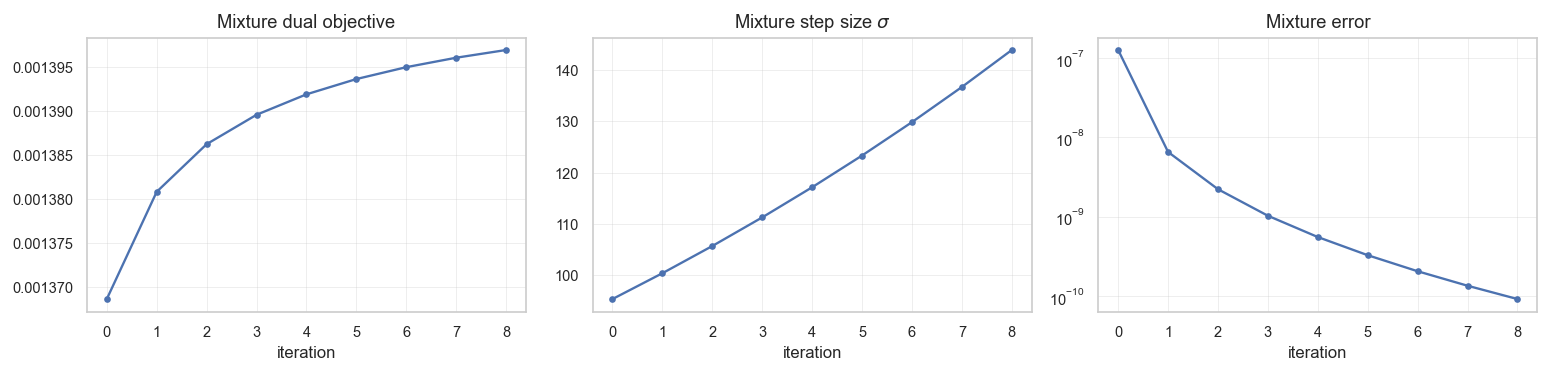

In [8]:

# Mixture example diagnostics
mix_metrics = {
    'dual objective': np.array(dual_mix[:it_mix]),
    r'step size $\sigma$': np.array(sigma_mix[:it_mix]),
    'error': np.clip(np.array(err_mix[:it_mix]), 1e-12, None),
}

fig, axes = plt.subplots(1, 3, figsize=(13, 3.2))
for ax, (title, data) in zip(axes, mix_metrics.items()):
    ax.plot(np.arange(it_mix), data, marker='o', linewidth=1.4, markersize=3)
    ax.set_title(f'Mixture {title}')
    ax.set_xlabel('iteration')
    if title == 'error':
        ax.set_yscale('log')
    ax.grid(True, linewidth=0.4, alpha=0.5)
plt.tight_layout()
plt.show()


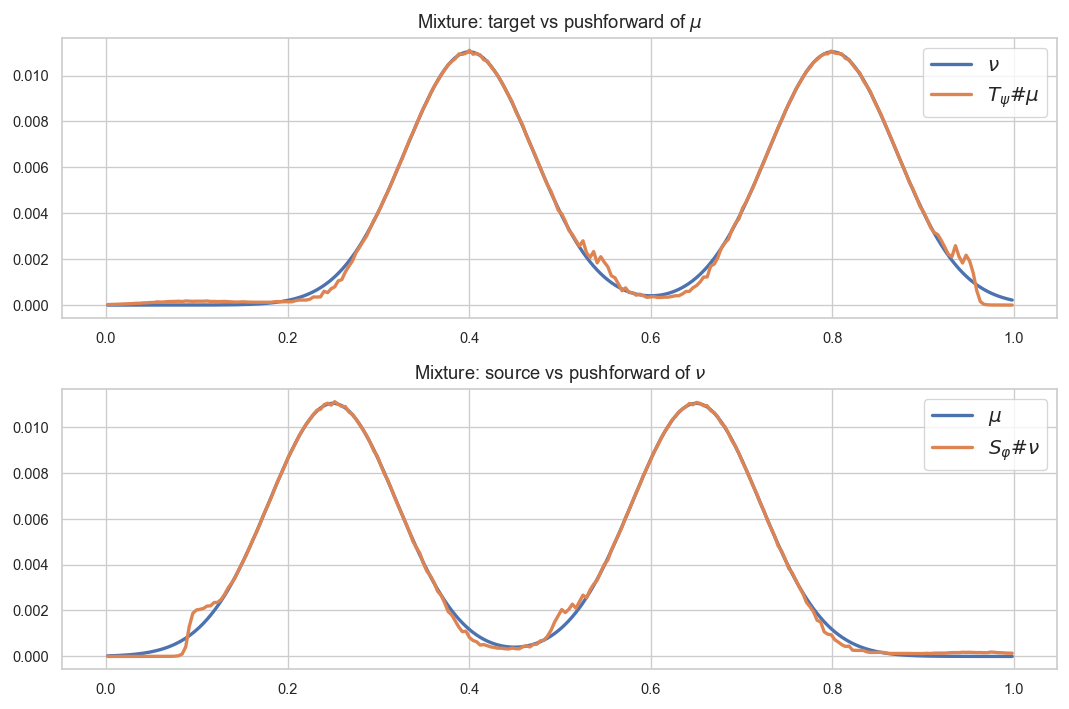

In [9]:

# Mixture pushforward comparison
rho_mu_mix = np.array(rho_mu_mix)
rho_nu_mix = np.array(rho_nu_mix)
fig, ax = plt.subplots(2, 1, figsize=(9, 6))
ax[0].plot(x2, nu_mix, label=r'$\nu$', linewidth=2)
ax[0].plot(x2, rho_mu_mix, label=r'$T_{\psi}\#\mu$', linewidth=2)
ax[0].legend()
ax[0].set_title(r'Mixture: target vs pushforward of $\mu$')
ax[1].plot(x2, mu_mix, label=r'$\mu$', linewidth=2)
ax[1].plot(x2, rho_nu_mix, label=r'$S_{\varphi}\#\nu$', linewidth=2)
ax[1].legend()
ax[1].set_title(r'Mixture: source vs pushforward of $\nu$')
plt.tight_layout()
plt.show()


### Piecewise-uniform example

The last example contrasts two measures that are uniform on disjoint intervals:
$$
\mu(x) \propto \mathbf{1}_{(1/8,\,3/8)}(x),\\
\nu(x) \propto \tfrac{3}{5} \cdot \mathbf{1}_{(0,\,1/8)}(x) + \tfrac{6}{5} \cdot \mathbf{1}_{(3/4,\,1)}(x).
$$
After discretization each is scaled so that it sums to one, producing two simple block densities for the solver.


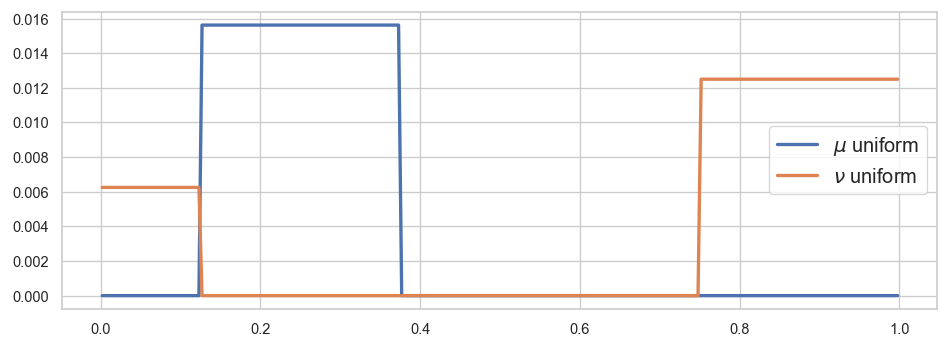

Uniform example converged in 9 iterations


In [25]:
# Uniform measures
x3 = np.linspace(0.5/n, 1 - 0.5/n, n)
cell_vol3 = x3[1] - x3[0]

mu_unif = np.zeros_like(x3)
mu_unif += 1.0 * ((x > 1/8) & (x < 3/8)).astype(float)
mu_unif *= cell_vol3
mu_unif /= mu_unif.sum()

nu_unif = np.zeros_like(x3)
nu_unif += (3/5) * ((x > 0) & (x < 1/8)).astype(float)
nu_unif += (6/5) * ((x > 3/4) & (x < 1)).astype(float)
nu_unif *= cell_vol3
nu_unif /= nu_unif.sum()

mu_unif_j = jax.device_put(mu_unif)
nu_unif_j = jax.device_put(nu_unif)
coords_unif = [jnp.asarray(x3, dtype=jnp.float64)]

fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(x2, mu_unif, label=r'$\mu$ uniform', linewidth=2)
ax.plot(x2, nu_unif, label=r'$\nu$ uniform', linewidth=2)
ax.legend()
plt.tight_layout()
plt.show()

result_unif = backnforth_sqeuclidean_nd(
    mu_unif_j, nu_unif_j, coords_unif,
    stepsize=(1 / max(mu_mix.max(), nu_mix.max())),
    maxiterations=max_iter,
    tolerance=1e-4,
    error_metric='h1_psi_relative',
    pushforward_fn=adaptive_pushforward_nd,
    progressbar=False,
    )
(it_unif, phi_unif, psi_unif, rho_nu_unif, rho_mu_unif, err_unif, dual_unif, sigma_unif) = result_unif
print(f"Uniform example converged in {int(it_mix)} iterations")


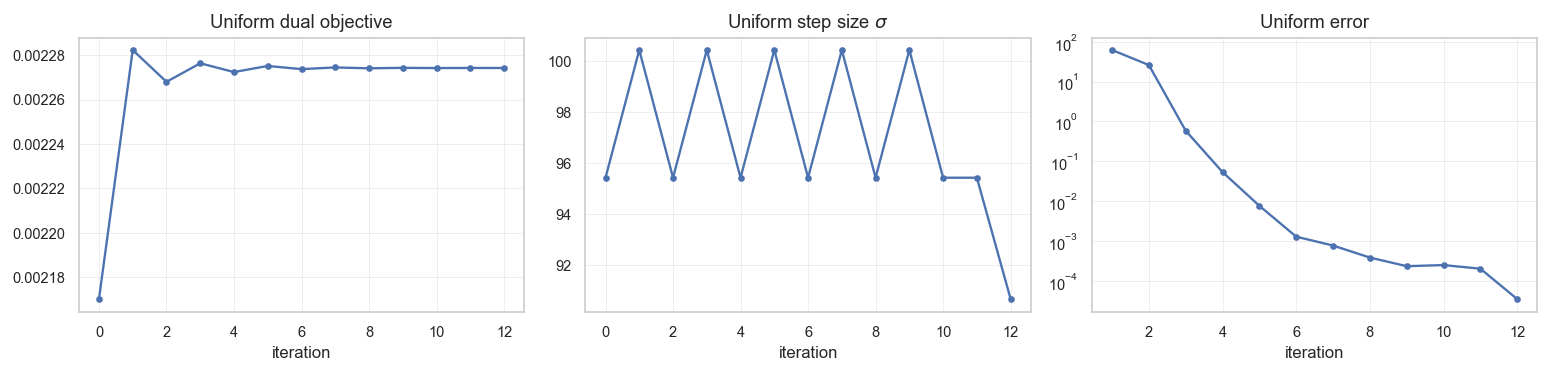

In [26]:
# Uniform example diagnostics
unif_metrics = {
    'dual objective': np.array(dual_unif[:it_unif]),
    r'step size $\sigma$': np.array(sigma_unif[:it_unif]),
    'error': np.clip(np.array(err_unif[:it_unif]), 1e-12, None),
}

fig, axes = plt.subplots(1, 3, figsize=(13, 3.2))
for ax, (title, data) in zip(axes, unif_metrics.items()):
    ax.plot(np.arange(it_unif), data, marker='o', linewidth=1.4, markersize=3)
    ax.set_title(f'Uniform {title}')
    ax.set_xlabel('iteration')
    if title == 'error':
        ax.set_yscale('log')
    ax.grid(True, linewidth=0.4, alpha=0.5)
plt.tight_layout()
plt.show()

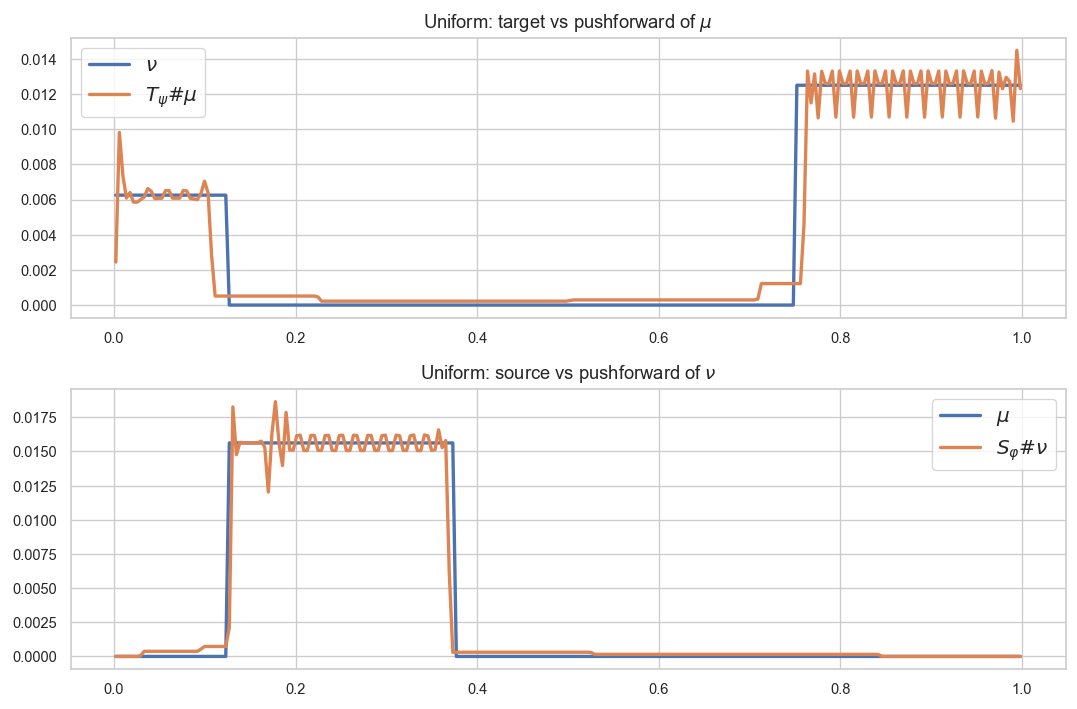

In [27]:
# Uniform pushforward comparison
rho_mu_unif = np.array(rho_mu_unif)
rho_nu_unif = np.array(rho_nu_unif)
fig, ax = plt.subplots(2, 1, figsize=(9, 6))
ax[0].plot(x2, nu_unif, label=r'$\nu$', linewidth=2)
ax[0].plot(x2, rho_mu_unif, label=r'$T_{\psi}\#\mu$', linewidth=2)
ax[0].legend()
ax[0].set_title(r'Uniform: target vs pushforward of $\mu$')
ax[1].plot(x2, mu_unif, label=r'$\mu$', linewidth=2)
ax[1].plot(x2, rho_nu_unif, label=r'$S_{\varphi}\#\nu$', linewidth=2)
ax[1].legend()
ax[1].set_title(r'Uniform: source vs pushforward of $\nu$')
plt.tight_layout()
plt.show()
